Initial attempt using a custom Gym environment

In [ ]:
import gym
from gym import spaces
import numpy as np

In [ ]:
# some utils

def mult(u, v, w):
  return np.multiply.outer(np.outer(u, v), w)

def matrix_multiplication_tensor(n, m, p):
  '''
  returns the tensor encoding the matrix multiplication C=AB
  A is nxm, B is mxp, C is nxp
  '''
  tensor = np.zeros((n * m, m * p, n * p))
  for row in range(n):
    for col in range(p):
      for i in range(m):
        tensor[row * m + i][i * p + col][row * p + col] = 1
        # since sum_i A[row][i] * B[i][col] = C[row][col]
  return tensor


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class TensorWorldEnv(gym.Env):

  def __init__(self, render_mode=None, size=(2,2,2), max_entry=1):

    (n, m, p) = size
    self.n = n
    self.m = m
    self.p = p
    self.max_entry = max_entry
    num_entries = 2 * max_entry + 1
    self.num_entries = num_entries

    self.num_states = num_entries ** ((n * m * p) ** 2)
    print(type(self.num_states))
    self.observation_space = spaces.Dict(
      {
        "agent": spaces.Discrete(self.num_states),
        "target": spaces.Discrete(1, start = (self.num_states - 1) // 2),
      }
    )

    self.num_actions = num_entries ** (n*m + m*p + p*n)
    self.action_space = spaces.Discrete(self.num_actions)
    # self._action_to_tensor = {a : mult(np.array([((a // (num_entries ** i)) % num_entries) - max_entry for i in range(n)]), np.array([((a // (num_entries ** (n+i))) % num_entries) - max_entry for i in range(m)]), np.array([((a // (num_entries ** (n+m+i))) % num_entries) - max_entry for i in range(p)])) for a in range(self.num_actions)}

  def _observation_to_tensor(self, a):
    (n, m, p) = (self.n, self.m, self.p)
    return np.reshape(np.array([((a // (self.num_entries ** i)) % self.num_entries) - self.max_entry for i in range((n*m*p)**2)]),(n*m,m*p,p*n))

  def _tensor_to_observation(self, tensor):
    squashed = tensor.flatten()
    return sum(np.array([((squashed[i] + self.max_entry) * self.num_entries ** i) for i in range(len(squashed))]))

  def step(self, action):
    action_tensor = self._action_to_tensor[action]
    next_observation = ...
    reward = ...
    done = ...
    return next_observation, reward, done, {}

  def reset(self, seed=None, options=None):
    super().reset(seed=seed)
    self._agent_location = matrix_multiplication_tensor(self.n, self.m, self.p) # use random start state if possible

env = TensorWorldEnv()
env.reset()
# print(env._agent_location)
print("2x2x2 multiplication tensor")
print(matrix_multiplication_tensor(2, 2, 2))
print("---------------------")
print("Tensor after collapsing and uncollapsing: ", env._tensor_to_observation(env._agent_location))
print(env._observation_to_tensor(env._tensor_to_observation(env._agent_location)))


<class 'int'>
2x2x2 multiplication tensor
[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]
---------------------
Tensor after collapsing and uncollapsing:  2.866113312278409e+30
[[[ 1.  0.  1.  0.]
  [ 1.  0.  1. -1.]
  [ 1. -1.  0. -1.]
  [ 0. -1. -1.  0.]]

 [[ 1.  1.  1. -1.]
  [ 0.  1.  1.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  1.  0.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  1.]]]


Even in the case when $(n,m,p)=(2,2,2)$, there are $3^{64}$ states in this simplified setting. This is one of the major challenges with this problem. Additionally, Python loses precision when it stores the int (I was unable to find a 128-bit integer import I could quickly use), so it is not feasible to enumerate all the states even in the easiest case without significant manual changes.

Second approach

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [23]:
def mult(u, v, w):
  return np.multiply.outer(np.outer(u, v), w)

def matrix_multiplication_tensor(n, m, p):
  '''
  returns the tensor encoding the matrix multiplication C=AB
  A is nxm, B is mxp, C is nxp
  '''
  tensor = np.zeros((n * m, m * p, n * p), dtype=int)
  for row in range(n):
    for col in range(p):
      for i in range(m):
        tensor[row * m + i][i * p + col][row * p + col] = 1
        # since sum_i A[row][i] * B[i][col] = C[row][col]
  return tensor

In [3]:
def synthetic_demonstrations(size=2, prob=.25, N=10000, seed=None):
  if seed:
    np.random.seed(seed)
  for _ in range(N):
    r = np.random.choice(range(1, size ** 3))
    factors = []
    t = np.zeros((size ** 2, size ** 2, size ** 2))
    for _ in range(r):
      x = np.zeros((size ** 2, size ** 2, size ** 2))
      while np.array_equal(x, np.zeros((size ** 2, size ** 2, size ** 2))):
        u = np.random.choice([-1,0,1], size ** 2, p=[prob, 1-2*prob, prob])
        v = np.random.choice([-1,0,1], size ** 2, p=[prob, 1-2*prob, prob])
        w = np.random.choice([-1,0,1], size ** 2, p=[prob, 1-2*prob, prob])
        x = mult(u,v,w)
      factors.append((u,v,w))
      t += x
    yield(t, factors)

def change_of_basis_matrices(size=2, prob=.25, N=1000, seed=None):
  if seed:
    np.random.seed(seed)
  for _ in range(N):
    P = np.zeros((size ** 2, size ** 2))
    L = np.zeros((size ** 2, size ** 2))
    for i in range(size ** 2):
      P[i][i] = np.random.choice([-1, 1])
      L[i][i] = np.random.choice([-1, 1])
    for i in range(size ** 2):
      for j in range(i):
        L[i][j] = np.random.choice([-1, 0, 1], p=[prob, 1-2*prob, prob])
      for j in range(i+1, size ** 2):
        P[i][j] = np.random.choice([-1, 0, 1], p=[prob, 1-2*prob, prob])
    yield np.multiply(P, L)



In [ ]:
# NO NEED TO RUN IF YOU ARE USING THE PRETRAINED MODEL

# adapted from https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

model = torch.nn.Sequential(
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1),
)
# You can mess around with the number of hidden nodes - 64 and 32 worked just about the same as 256 and 64

loss_fn = torch.nn.HuberLoss(reduction='sum')
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

999 1.1543772305262492
1999 0.9054980651578262
2999 0.8567428051674439
3999 0.8863778525264443
4999 0.8765376240460128
5999 0.7971779884651368
6999 0.7978170013798405
7999 0.8205831881547393
8999 0.7913325063929262
9999 0.7679085326770839
10999 0.8098791383885473
11999 0.769053343014619
12999 0.8037738015031828
13999 0.7719581249923696
14999 0.7570917615354333
15999 0.7932098320224049
16999 0.8027782264788123
17999 0.7730773675690825
18999 0.7780367698564519
19999 0.685120728038331
20999 0.7486543439413618
21999 0.747420214500613
22999 0.7538609446468287
23999 0.7751296189116481
24999 0.680290840922757
25999 0.7615536643392424
26999 0.7258037155683756
27999 0.7199928194971542
28999 0.7327863601689615
29999 0.7481753186308595
30999 0.6966775461926036
31999 0.7303279376518823
32999 0.6926841638519401
33999 0.7372408695780346
34999 0.7420042139530023
35999 0.6997968213691924
36999 0.7437732054707141
37999 0.6881581310201694
38999 0.7097700261223491
39999 0.717546468311695
40999 0.77221924

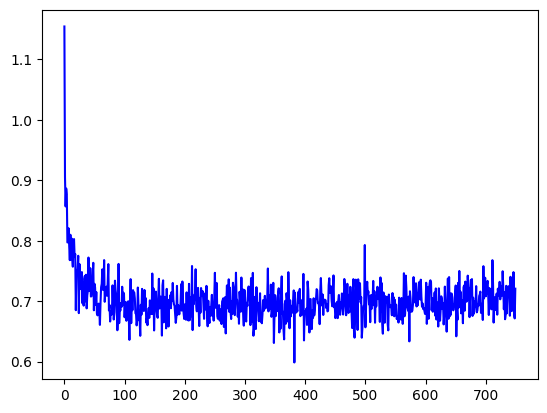

In [ ]:
# NO NEED TO RUN IF YOU ARE USING THE PRETRAINED MODEL

# Training model
losses = []
rounds = 750
N_factorizations = 1000  # Every 1000 factorizations takes about 1 second

for i in range(rounds):

  # Generate factorizations
  factorizations = list(synthetic_demonstrations(N=N_factorizations))

  loss_sum = 0
  for t in range(N_factorizations):

      # Forward pass: compute predicted y by passing x to the model.
      y_pred = model(torch.tensor(factorizations[t][0].flatten(), dtype=torch.float32))

      # Compute and print loss.
      loss = loss_fn(y_pred, torch.tensor(-len(factorizations[t][1]), dtype=torch.float32))
      loss_sum += loss.item()
      if t % 1000 == 999:
          losses.append(loss_sum/1000)
          print(i*N_factorizations+t, loss_sum/1000)
          loss_sum = 0

      # Before the backward pass, use the optimizer object to zero all of the
      # gradients for the variables it will update (which are the learnable
      # weights of the model). This is because by default, gradients are
      # accumulated in buffers( i.e, not overwritten) whenever .backward()
      # is called. Checkout docs of torch.autograd.backward for more details.
      optimizer.zero_grad()

      # Backward pass: compute gradient of the loss with respect to model
      # parameters
      loss.backward()

      # Calling the step function on an Optimizer makes an update to its
      # parameters
      optimizer.step()

plt.plot(range(rounds), losses, color='blue')

In [ ]:
# NO NEED TO RUN IF YOU ARE USING THE PRETRAINED MODEL
torch.save(model, "model-64-32.pt")

In [5]:
# RUN ONLY IF YOU ARE USING THE PRETRAINED MODEL
model = torch.load("model-256-64.pt")
model.eval()

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
def get_rank_one_matrices():
  num_entries = 3
  max_entry = 1
  n = 4
  m = 4
  p = 4
  num_actions = 3 ** 12
  return { tuple(mult(np.array([((a // (3 ** i)) % num_entries) - max_entry for i in range(n)]), np.array([((a // (num_entries ** (n+i))) % num_entries) - max_entry for i in range(m)]), np.array([((a // (num_entries ** (n+m+i))) % num_entries) - max_entry for i in range(p)])).flatten()) for a in range(num_actions)}

rank_one_matrices_set = get_rank_one_matrices()
rank_one_matrices_array = np.array(list(rank_one_matrices_set))

print(len(rank_one_matrices_array))

128001


In [7]:
def get_random_action():
  return np.array(rank_one_matrices_array[np.random.randint(len(rank_one_matrices_array))]).reshape((4,4,4))

T_2 = matrix_multiplication_tensor(2,2,2)

def get_rotated_start(A,B,C):
  T = np.zeros((4,4,4))
  for i in range(4):
    for j in range(4):
      for k in range(4):
        for a in range(4):
          for b in range(4):
            for c in range(4):
              T[i][j][k] += int(A[i][a] * B[j][b] * C[k][c] * T_2[a][b][c])
  return T

In [20]:
def search():
  for trial in range(100000):
    if trial % 100 == 0:
      print(trial)
      cob_matrices = list(change_of_basis_matrices(N=3))
      start = get_rotated_start(cob_matrices[0], cob_matrices[1], cob_matrices[2])

    s = start
    actions = []

    for _ in range(6):
      s_estimate = model(torch.tensor(s.flatten(), dtype=torch.float32)).item()
      best_a = None
      best_improvement_estimate = -100

      for _ in range(16):

        a = get_random_action()
        while abs(s-a).max() >= 2:
          a = get_random_action()
        s_prime_estimate = model(torch.tensor((s-a).flatten(), dtype=torch.float32)).item()
        if s_prime_estimate > best_improvement_estimate:
          best_a = a
          best_improvement_estimate = s_prime_estimate

      s = s - best_a
      actions.append(best_a)

    if tuple(s.flatten().astype(int)) in rank_one_matrices_set:
      print(s, actions, cob_matrices[0], cob_matrices[1], cob_matrices[2])


In [21]:
search()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [55]:
# Not much more effective

import threading

if __name__ == "__main__":
  threads = list()
  for index in range(10):
      x = threading.Thread(target=search, args=[])
      threads.append(x)
      x.start()
  for index, thread in enumerate(threads):
      thread.join()

0
0
0
0
0
0
0
0
00



KeyboardInterrupt: 

Third try (follow-up experiment) - This could probably be more optimized in C++ or Rust. Many of the operations I use when searching are bitwise.

In [7]:
import numpy as np

def mult(u, v, w):
  return np.multiply.outer(np.outer(u, v), w)

def matrix_multiplication_tensor(n, m, p):
  '''
  returns the tensor encoding the matrix multiplication C=AB
  A is nxm, B is mxp, C is nxp
  '''
  tensor = np.zeros((n * m, m * p, n * p), dtype=int)
  for row in range(n):
    for col in range(p):
      for i in range(m):
        tensor[row * m + i][i * p + col][row * p + col] = 1
        # since sum_i A[row][i] * B[i][col] = C[row][col]
  return tensor

In [8]:
# Takes about 2 minutes

def get_rank_one_matrices_mod2():
  num_entries = 2
  max_entry = 0
  n = 4
  m = 4
  p = 4
  num_actions = 2 ** 12
  return { tuple(mult(np.array([((a // (num_entries ** i)) % num_entries) - max_entry for i in range(n)]), np.array([((a // (num_entries ** (n+i))) % num_entries) - max_entry for i in range(m)]), np.array([((a // (num_entries ** (n+m+i))) % num_entries) - max_entry for i in range(p)])).flatten()) for a in range(num_actions)}

rank_one_matrices_mod2_set = get_rank_one_matrices_mod2()
rank_one_matrices_mod2_array = np.array(list(rank_one_matrices_mod2_set))

print(len(rank_one_matrices_mod2_array))
print("should be at most ", 2 ** 12)

# Needed to conserve RAM
def encode(t):
  i = 0
  for bit in t:
    i = i << 1 | bit
  return i

rank_one_matrices_encodings_mod2_array = np.array([encode(t) for t in rank_one_matrices_mod2_array])
rank_one_matrices_encodings_mod2_set = set(rank_one_matrices_encodings_mod2_array)

def get_rank_two_matrices_encodings_mod2():
  s = set()
  for i in range(len(rank_one_matrices_mod2_array)):
    if i % 100 == 0:
      print(i, len(s))
    for j in range(i):
      s.add(encode(tuple((rank_one_matrices_mod2_array[i] + rank_one_matrices_mod2_array[j]) % 2)))
  return s

rank_two_matrices_encodings_mod2_set = get_rank_two_matrices_encodings_mod2()
rank_two_matrices_encodings_mod2_array = np.array(list(rank_two_matrices_encodings_mod2_set))
print(len(rank_two_matrices_encodings_mod2_set))

3376
should be at most  4096
0 0
100 4950
200 19876
300 44747
400 79509
500 124048
600 178219
700 241959
800 315181
900 397410
1000 488787
1100 589180
1200 698394
1300 816323
1400 942905
1500 1077577
1600 1220842
1700 1371116
1800 1528058
1900 1693999
2000 1866926
2100 2047324
2200 2235045
2300 2430594
2400 2633203
2500 2842124
2600 3057227
2700 3279424
2800 3508307
2900 3744311
3000 3987124
3100 4236789
3200 4493720
3300 4758332
4964625


In [9]:
def get_random_action_mod2():
  return rank_one_matrices_encodings_mod2_array[np.random.randint(len(rank_one_matrices_encodings_mod2_array))]
  # return np.array(rank_one_matrices_mod2_array[np.random.randint(len(rank_one_matrices_mod2_array))]).reshape((4,4,4))

def get_random_double_action_mod2():
  encoding = rank_two_matrices_encodings_mod2_array[np.random.randint(len(rank_two_matrices_encodings_mod2_array))]
  return encoding
  # return np.array([(encoding >> i & 0x1) for i in range(63, -1, -1)]).reshape((4,4,4))

In [12]:
T_2 = encode(tuple(matrix_multiplication_tensor(2,2,2).flatten()))

def search_mod2():
  for trial in range(1000000000):
    if trial % 1000000 == 0:
      print(trial)

    s = T_2
    actions = []

    for i in range(5):
      for _ in range(100): # Try at most 100 different actions
        a = get_random_action_mod2()
        use_a = True
        for previous_a in actions:
          if (a ^ previous_a) in rank_one_matrices_encodings_mod2_set:
            use_a = False
            break
        if use_a:
          actions.append(a)
          s = s ^ a
          break

    if s in rank_two_matrices_encodings_mod2_set:
      print(s, actions)


In [16]:
search_mod2()

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000
65000000
66000000
67000000
68000000
69000000
70000000
71000000
72000000
73000000
74000000
75000000
76000000
77000000
78000000
79000000
80000000
81000000
82000000
83000000
84000000
85000000
86000000
87000000
88000000
89000000
90000000
91000000
92000000
93000000
94000000
95000000
96000000
97000000
98000000
99000000
100000000
101000000
102000000
103000000
104000000
105000000
106000000
107000000
108000000
109000000
110000000
111000

KeyboardInterrupt: 